# Credit Analysis Project

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -U scikit-learn
!pip install scikit-plot

# Data pre-processing

### Imports and dataset loading

In [3]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score

The process we will follow to partition data is described on the chart bellow

In [4]:
df = pd.read_table('gdrive/MyDrive/TRNcod.xls')

df.dropna(inplace = True)

df.head()

,INDEX,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,0,1,1,1,0,0,0,0,0.135098,1,...,0,0,1,1,0,1,1,1,0,1
1,1,1,0,1,0,0,1,0,0.273504,1,...,0,1,0,1,1,0,0,0,1,0
2,2,1,0,1,0,0,1,0,0.281910,0,...,1,1,0,0,0,0,1,0,1,0
3,3,1,1,1,0,0,0,0,0.225741,0,...,1,1,0,1,1,0,1,0,1,0
4,4,1,1,0,0,0,1,0,0.480403,0,...,1,1,1,0,0,1,0,1,1,0


In [5]:
print('Quantidade de instâncias: {}\nQuantidade de atributos: {}\n'.format(len(df), len(df.columns)))

Quantidade de instâncias: 389196
Quantidade de atributos: 246



### First Step: 
#### Splitting the Dataset on Two Classes

In [6]:
df['IND_BOM_1_2'].value_counts()

0    255098
1    134098
Name: IND_BOM_1_2, dtype: int64

In [7]:
df0 = df.loc[(df['IND_BOM_1_2']) == 0]
print('Quantidade de instâncias na classe 0 :' + str(len(df0)))

Quantidade de instâncias na classe 0 :255098


In [8]:
df1 = df.loc[(df['IND_BOM_1_2']) == 1]
print('Quantidade de instâncias na classe 1 :' + str(len(df1)))

Quantidade de instâncias na classe 1 :134098


### Second Step: 
#### Splitting on train, test and validation and augmenting to compensate data bias

In [9]:
#First we shuffle the dataset
df0 = df0.sample(frac=1, random_state=33)
#Then we split the dataset in three
len_df0 = len(df0)
train_0, validate_0, test_0 = df0[0:int(len_df0*.5)], df0[int(len_df0*.5):int(len_df0*.75)], df0[int(len_df0*.75):]

print("Size of train_0: ", len(train_0), "\nSize of validate_0: ", len(validate_0), "\nSize of test_0:", len(test_0))

Size of train_0:  127549 
Size of validate_0:  63774 
Size of test_0: 63775


In [10]:
#First we shuffle the dataset
df1 = df1.sample(frac=1, random_state=33)
#Then we split the dataset in three
len_df1 = len(df1)
train_1, validate_1, test_1 = df1[0:int(len_df1*.5)], df1[int(len_df1*.5):int(len_df1*.75)], df1[int(len_df1*.75):]

print("Size of train_1: ", len(train_1), "\nSize of validate_1: ", len(validate_1), "\nSize of test_1:", len(test_1))

Size of train_1:  67049 
Size of validate_1:  33524 
Size of test_1: 33525


#### We can see that class 1 contains less samples than class 0, thus we must perform a augmentation on out data to avoid a biased train

In [11]:
train_data_ratio = len(train_1)/len(train_0)
validate_data_ratio = len(validate_1)/len(validate_0)

#We augment our data multiplying its size by 1/ratio 
new_train_1_len = int(len(train_1)/train_data_ratio)
new_validate_1_len = int(len(validate_1)/validate_data_ratio)

#We get a random sample that has the size we need to augment our data
train_1_aug = train_1.sample(frac=1, random_state = 33)[:new_train_1_len - len(train_1)]
validate_1_aug = validate_1.sample(frac=1, random_state = 33)[:new_validate_1_len - len(validate_1)]

#Finally, we concatenate our data with the augmentation data
train_1 = pd.concat([train_1, train_1_aug])
validate_1 = pd.concat([validate_1, validate_1_aug])

print("New train_1 len: " ,len(train_1), "\nNew validate_1 len: ", len(validate_1))

New train_1 len:  127549 
New validate_1 len:  63774


### Third Step:
#### Rejoining the and shuflling datasets

In [12]:
train = pd.concat([train_0, train_1]).sample(frac=1, random_state=33)
validate = pd.concat([validate_0, validate_1]).sample(frac=1, random_state=33)
#The test set does not need to be shuflled
test = pd.concat([test_0, test_1])

# Data Classification

## Separating inputs from predictions

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
class RiskAnalysisDataset(Dataset):
    
    def __init__(self, data_features, data_labels):
        self.data_features = torch.tensor(data_features.copy()).float()
        self.data_labels = torch.tensor(data_labels.copy()).float()
    
    def __len__(self):
        return len(self.data_features)
    
    def __getitem__(self, index):
        return self.data_features[index], self.data_labels[index]
        

train_x = train.iloc[:, 0:244]
train_Y = train.iloc[:, -1]
train_data = RiskAnalysisDataset(train_x.values, train_Y.values)
# variar batch train_loader = DataLoader(train_data, batch_size)

validation_x = validate.iloc[:, 0:244]
validation_Y = validate.iloc[:, -1]
validation_data = RiskAnalysisDataset(validation_x.values, validation_Y.values)

#train and validation for gradient boosting
train_and_validation_x = pd.concat([train_x, validation_x])
train_and_validation_Y = pd.concat([train_Y, validation_Y])

#fraction of validation
validation_fraction = len(validation_x.values)/len(train_x.values)
validation_fraction

test_x = test.iloc[:, 0:244]
test_Y = test.iloc[:, -1]
test_data = RiskAnalysisDataset(test_x.values, test_Y.values)

## Metrics used for evaluation

Aqui são criadas as funções para avaliação de desempenho dos modelos que serão avaliados. Nelas estão inclusas o KS, auroc, MSE, confusion_matrix e classification_report.

In [ ]:
from sklearn.metrics import roc_curve, auc, mean_squared_error, confusion_matrix, classification_report
from scipy.stats import ks_2samp
import scikitplot as skplt
import matplotlib
import matplotlib.pyplot as plt

def ks_stat(y, yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic

def get_metrics(y, yhat, y_proba=None):
  results = dict()

  
  if (y_proba is not None):
    skplt.metrics.plot_ks_statistic(y, y_proba)
    plt.show()
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y, yhat)
  results['auroc'] = auc(false_positive_rate, true_positive_rate)
 # results['KS'] = ks_stat(y, y_proba)
  results['MSE'] = mean_squared_error(y,yhat)
  results['confusion_matrix'] = confusion_matrix(y,yhat)
  results['classification_report'] = classification_report(y,yhat)
  for key in results:
    print(key, ' ' , str(results[key]))
  return results

## pytorch MLP (bad results, possibly due to bugs)

O primeiro modelo a ser avaliado foi o MLP. Nós tivemos alguns problemas de implementação em pytorch e após sucessivas tentativas e experimentos optamos por abandonar essa implementação e realizar novamente os experimentos utilizando a biblioteca SkLearn. Apesar disso, esse momento de implementação em pytorch foi bastante construtivo, tivemos a oportunidade de implementar com as próprias mãos muito do que é necessário para o funcionamento de um perceptron e para a visualização de dados. Devido às limitações do ambiente colab, também foi necessário implementar funções que salvavam periodicamente o modelo que estava sendo treinado de modo integrado ao google drive. Isso nos permitiu continuar os treinos do ponto onde eles foram parados, sem perder a computação já efetuada previamente.

Apesar de algumas funções não funcionarem como esperado no MLP do pytorch, nos obtivemos muitos insights sobre de que modo deveriamos continuar nossos experimentos posteriormente. Verificamos, por exemplo, que a função de loss mais efetiva para o problema sendo atacado era a MSE, e que uma rede pequena, com 5 neurônios e uma camada escondida, já era capaz de aprender, com certa eficiência, a classificar o conjunto de dados. Também notamos que um grid search era um método impraticável para mapear os melhores parâmeros, devido ao alto custo de computação.

### Class defining our Multi-layer Perceptron

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, input_size, num_neurons, num_hidden_layers, activation_func, cross_entropy=True):
      super(MLP, self).__init__()
      self.input_size = input_size
      self.num_neurons  = num_neurons
      self.num_hidden_layers = num_hidden_layers
      self.activation_func = activation_func
      self.sigmoid = torch.nn.Sigmoid()
      self.fc1 = torch.nn.Linear(self.input_size, self.num_neurons)
      self.cross_entropy = cross_entropy
      #Use ModuleList instead of regular list, due to optimizer definition
      self.hidden_layers = torch.nn.ModuleList()
      #hidden_layers
      for i in range(self.num_hidden_layers):
        self.hidden_layers.append(torch.nn.Linear(self.num_neurons, self.num_neurons))
      self.fc2 = torch.nn.Linear(self.num_neurons, 2)
  def forward(self, x):
      x = self.fc1(x)
      x = self.activation_func(x)
      for i in range(self.num_hidden_layers):
        x = self.hidden_layers[i](x)
        x = self.activation_func(x)
      x = self.fc2(x)
      #Unnecessary due to cross entropy
      if (not self.cross_entropy):
        x = self.sigmoid(x)
      return x


### Training and testing functions

In [ ]:
from genericpath import isfile
import tqdm.notebook
import os
criterion_dict = {'cross_entropy': torch.nn.CrossEntropyLoss(), 'MSE': torch.nn.MSELoss()}
def fit(model, train_loader, criterion, optimizer):
  iter = tqdm.notebook.tqdm(train_loader, leave = False)
  model.train()
  for x,y in iter:
    yhat = model(x)
    if (criterion == 'MSE'):
      bin_yhat = torch.max(yhat,dim=1).values
      loss = criterion_dict[criterion](bin_yhat, y)
    elif (criterion == 'cross_entropy'):
      y = y.type(torch.LongTensor)
      loss = criterion_dict[criterion](yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test(model, test_loader, criterion, epoch = 0):
  losses = []
  total_loss = 0
  all_preds = torch.tensor([])
  all_preds_proba = torch.tensor([])
  all_targets = torch.tensor([])
  iter = tqdm.notebook.tqdm(test_loader, leave = False)
  model.eval()
  with torch.no_grad():
    for x,y in iter:
      yhat = model(x)
      if (criterion == 'MSE'):
        bin_yhat = torch.max(yhat,dim=1).values
        loss = criterion_dict[criterion](bin_yhat, y)
      elif (criterion == 'cross_entropy'):
        y = y.type(torch.LongTensor)
        loss = criterion_dict[criterion](yhat, y)
      #losses.append(loss)
      total_loss+=loss.item()
      all_preds = torch.cat((all_preds, yhat.argmax(dim=1)))
      all_preds_proba = torch.cat((all_preds_proba, yhat))
      all_targets = torch.cat((all_targets, y))
 
  return total_loss/len(test_loader), (all_targets.tolist(), all_preds.tolist(), all_preds_proba.tolist())

def saveLosses(losses, epoch, path, name):
    full_path = "{}/losses_{}.csv".format(path, name)
    if not (os.path.isfile(full_path)):
      df = pd.DataFrame({"loss": losses,"epoch": [*range(epoch+1)]})
      df.to_csv("{}/losses_{}.csv".format(path, name))
    else:
      df = pd.read_csv(full_path)
      saved_losses = df["loss"].tolist()
      saved_epoch = df["epoch"].tolist()
      saved_losses.append(losses[len(losses)-1])
      losses = saved_losses
      saved_epoch.append(epoch+saved_epoch[len(saved_epoch)-1]+1)
      df = pd.DataFrame({"loss": saved_losses,"epoch": saved_epoch})
      df.to_csv("{}/losses_{}.csv".format(path, name))
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
def plotLossGraph(path):
    df = pd.read_csv(path)
    saved_losses = df["loss"].tolist()
    plt.plot(saved_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

def save(losses, epoch, model, optimizer, optimizer_name, criterion, lr, num_hidden, num_neuron, activation, best = False):
    save_path = "gdrive/MyDrive/models_backup"
    if not (os.path.isdir(save_path)):
      os.makedirs(save_path)
    name = "_optim_{}_criterion_{}_lr_{}_num_hidden_{}_num_neuron_{}_activation{}.pt".format(str(optimizer_name), criterion, lr, num_hidden, num_neuron, activation)
    if(best):
      torch.save(model.state_dict(), "{}/model_best{}".format(save_path, name))
      torch.save(optimizer.state_dict(), "{}/optimizer_best{}".format(save_path, name))
      pass
    else:
      saveLosses(losses, epoch, save_path, name)
      torch.save(model.state_dict(), "{}/model_last{}".format(save_path, name))
      torch.save(optimizer.state_dict(), "{}/optimizer_last{}".format(save_path, name))

def train_and_evaluation(model, optimizer, optimizer_name, criterion, lr, num_hidden, num_neuron, activation, train_data, validation_data, test_data, batch_size= 128, pacience = 20, max_epochs = 10000, min_epochs = 0):
  """
  Function that performs full train and test of a given MLP class model.
  Parameters:
    model: pytorch model
    criterion: string naming the criterion to be used during train
    optimizer: torch optmizer to be used during train
    optimizer_name: string naming the optimizer
    train_data: torch utils Dataset containing train data
    validation_data: torch utils Dataset containing validation data
    test_data: torch utils Dataset containing test data
    batch_size: batch size
    pacience: defines the number of epochs with loss decrease on validation data that can be tolerated before training stops
    max_epochs: the minimum number of epochs
    min_epochs: the maximum number of epochs
  """
  counter = 0
  current_loss = 0
  last_loss = 0
  best_loss = 10000
  losses = []
  batch_size = 8
  train_loader = DataLoader(train_data, batch_size)
  validation_loader = DataLoader(validation_data, batch_size)
  test_loader = DataLoader(test_data, batch_size)
  iter = tqdm.notebook.tqdm(range(max_epochs), leave = False)
  for epoch in (iter):
    # print(f"Epoch {epoch} ")
    fit(model, train_loader, criterion, optimizer)
    current_loss, _ = test(model, validation_loader, criterion, epoch)
    losses.append(current_loss)
    print("Validation loss: ", current_loss)
    #Model backup
    if current_loss<best_loss:
      best_loss = current_loss
      save(losses, epoch, model, optimizer, optimizer_name, criterion, lr, num_hidden, num_neuron, activation, best=True)
    save(losses, epoch, model, optimizer, optimizer_name, criterion, lr, num_hidden, num_neuron, activation, best=False)
    #Pacience and overfit avoidance
    if (current_loss >= last_loss and epoch>min_epochs):
      counter = counter + 1
      losses_last_ten = losses[len(losses)-20:]
      # average_recent_loss = sum(losses_last_ten)/len(losses_last_ten)
      # if ((counter == pacience or current_loss>average_recent_loss)):
      if (counter == pacience):
        break
    else:
      counter = 0
    last_loss = current_loss
    current_loss = 0
  #Final Evaluation
  loss, (all_targets, all_preds, all_preds_proba) = test(model, test_loader, criterion)
  print("Loss on test set: " , loss)
  return get_metrics(all_targets, all_preds, all_preds_proba)


### Experiments

#### Functions

In [ ]:
#auxiliary function
def get_optim(optim, model, lr):
  if('SGD' == optim):
    return torch.optim.SGD(model.parameters(), lr = lr)
  if('adam' == optim):
    return torch.optim.Adam(model.parameters(), lr = lr)
  if('adagrad' == optim):
    return torch.optim.Adagrad(model.parameters(), lr = lr)

In [ ]:
MLP_results = []
optimizers = ['adagrad']
#lrs = [0.000, 0.015, 0.3]
lrs = [0.0005]
hidden_ls = [2]
#neurons = [5,30,100]
neurons = [5]
activation_func = [torch.nn.ReLU()]
criterions = ['MSE']

# if continuing training on saved model
model = MLP(244, 5, 2, torch.nn.ReLU())
#19:26
model.load_state_dict(torch.load("gdrive/MyDrive/models_backup/model_last_optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_2_num_neuron_5_activationReLU() (12).pt"))
optimizer = get_optim('adagrad', model, 0.0005)
#20 19:01, 19 20:05, 18 19:55, 17 19:45, 16 19:09, 15, 19:35 14: 19:17, 13 19:25
optimizer.load_state_dict(torch.load("gdrive/MyDrive/models_backup/optimizer_last_optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_2_num_neuron_5_activationReLU() (14).pt"))
for optim in optimizers:
  for lr in lrs:
    for num_hidden in hidden_ls:
      for num_neuron in neurons:
        for activation in activation_func:
          for criterion in criterions:
            out = "Optim: {} - lr: {} - num_hidden: {} - num_neuron: {} - activation: {} - criterion: {}"
            print(out.format(optim,lr,num_hidden,num_neuron,activation,criterion))
            
            # model = MLP(244, num_neuron, num_hidden, activation, cross_entropy=False)
            # optimizer = get_optim(optim, model, lr)
            result = train_and_evaluation(model, optimizer, optim, criterion, lr, num_hidden, num_neuron, activation, train_data, validation_data, test_data, pacience = 30)
            MLP_results.append(result)

#### Results

  0%|          | 0/761 [00:00<?, ?it/s]

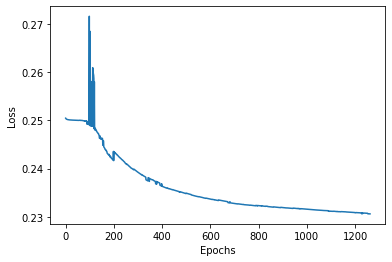

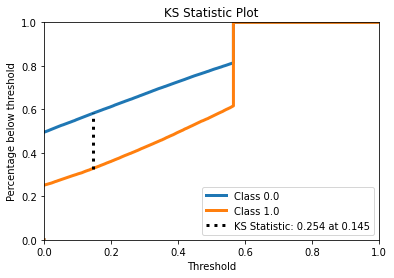

auroc   0.5111377299072084
MSE   0.6385097636176773
confusion_matrix   [[ 1900 61875]
 [  252 33273]]
classification_report                 precision    recall  f1-score   support

         0.0       0.88      0.03      0.06     63775
         1.0       0.35      0.99      0.52     33525

    accuracy                           0.36     97300
   macro avg       0.62      0.51      0.29     97300
weighted avg       0.70      0.36      0.22     97300



{'MSE': 0.6385097636176773,
 'auroc': 0.5111377299072084,
 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.88      0.03      0.06     63775\n         1.0       0.35      0.99      0.52     33525\n\n    accuracy                           0.36     97300\n   macro avg       0.62      0.51      0.29     97300\nweighted avg       0.70      0.36      0.22     97300\n',
 'confusion_matrix': array([[ 1900, 61875],
        [  252, 33273]])}

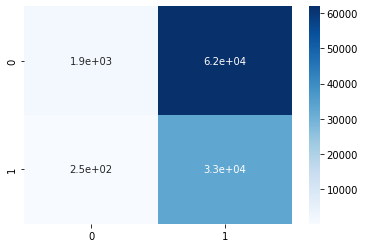

In [ ]:
train_loader = DataLoader(train_data, 128)
test_loader = DataLoader(test_data, 128)
validation_loader = DataLoader(validation_data, 128)
model = MLP(244, 5, 1, torch.nn.ReLU())
model.load_state_dict(torch.load("gdrive/MyDrive/models_backup/model_last_optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_1_num_neuron_5_activationReLU().pt"))
loss, (all_targets, all_preds, all_preds_proba) = test(model, test_loader, 'cross_entropy')
plotLossGraph("gdrive/MyDrive/models_backup/losses__optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_1_num_neuron_5_activationReLU().pt.csv")
get_metrics(all_targets, all_preds, all_preds_proba)

  0%|          | 0/761 [00:00<?, ?it/s]

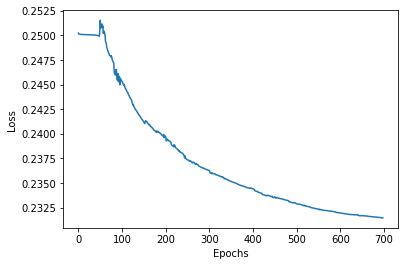

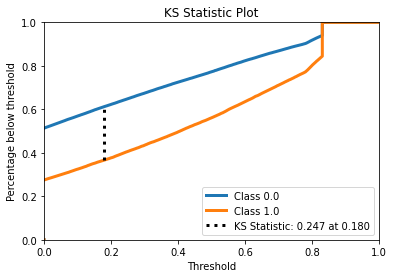

auroc   0.5271542004699945
MSE   0.6123021582733813
confusion_matrix   [[ 5012 58763]
 [  814 32711]]
classification_report                 precision    recall  f1-score   support

         0.0       0.86      0.08      0.14     63775
         1.0       0.36      0.98      0.52     33525

    accuracy                           0.39     97300
   macro avg       0.61      0.53      0.33     97300
weighted avg       0.69      0.39      0.27     97300



{'MSE': 0.6123021582733813,
 'auroc': 0.5271542004699945,
 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.86      0.08      0.14     63775\n         1.0       0.36      0.98      0.52     33525\n\n    accuracy                           0.39     97300\n   macro avg       0.61      0.53      0.33     97300\nweighted avg       0.69      0.39      0.27     97300\n',
 'confusion_matrix': array([[ 5012, 58763],
        [  814, 32711]])}

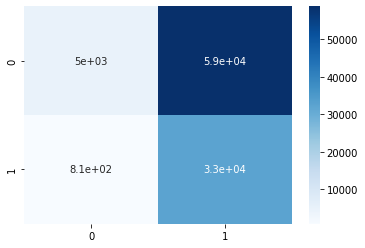

In [ ]:
model = MLP(244, 5, 2, torch.nn.ReLU())
model.load_state_dict(torch.load("gdrive/MyDrive/models_backup/model_last_optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_2_num_neuron_5_activationReLU() (12).pt"))
loss, (all_targets, all_preds, all_preds_proba) = test(model, test_loader, 'cross_entropy')
plotLossGraph("gdrive/MyDrive/models_backup/losses__optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_2_num_neuron_5_activationReLU().pt.csv")
get_metrics(all_targets, all_preds, all_preds_proba)

  0%|          | 0/761 [00:00<?, ?it/s]

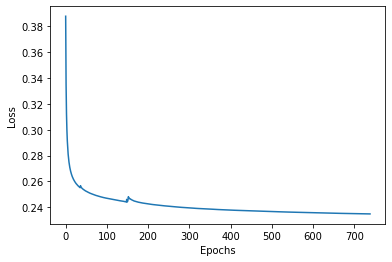

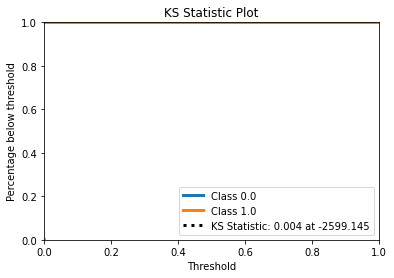

auroc   0.5
MSE   0.34455292908530316
confusion_matrix   [[63775     0]
 [33525     0]]
classification_report                 precision    recall  f1-score   support

         0.0       0.66      1.00      0.79     63775
         1.0       0.00      0.00      0.00     33525

    accuracy                           0.66     97300
   macro avg       0.33      0.50      0.40     97300
weighted avg       0.43      0.66      0.52     97300



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'MSE': 0.34455292908530316,
 'auroc': 0.5,
 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.66      1.00      0.79     63775\n         1.0       0.00      0.00      0.00     33525\n\n    accuracy                           0.66     97300\n   macro avg       0.33      0.50      0.40     97300\nweighted avg       0.43      0.66      0.52     97300\n',
 'confusion_matrix': array([[63775,     0],
        [33525,     0]])}

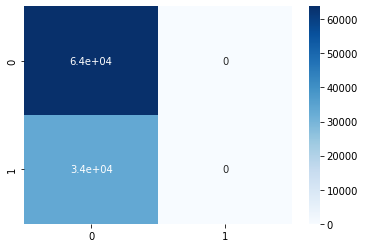

In [ ]:
model = MLP(244, 25, 1, torch.nn.ReLU())
model.load_state_dict(torch.load("gdrive/MyDrive/models_backup/model_last_optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_1_num_neuron_25_activationReLU().pt"))
loss, (all_targets, all_preds, all_preds_proba) = test(model, test_loader, 'cross_entropy')
plotLossGraph("gdrive/MyDrive/models_backup/losses__optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_1_num_neuron_25_activationReLU().pt.csv")
get_metrics(all_targets, all_preds, all_preds_proba)

  0%|          | 0/761 [00:00<?, ?it/s]

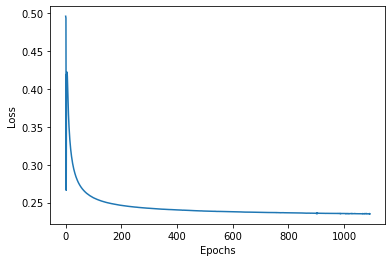

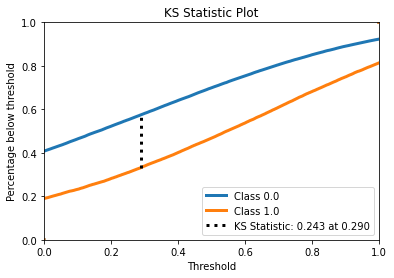

auroc   0.5000078400627205
MSE   0.6554367934224049
confusion_matrix   [[    1 63774]
 [    0 33525]]
classification_report                 precision    recall  f1-score   support

         0.0       1.00      0.00      0.00     63775
         1.0       0.34      1.00      0.51     33525

    accuracy                           0.34     97300
   macro avg       0.67      0.50      0.26     97300
weighted avg       0.77      0.34      0.18     97300



{'MSE': 0.6554367934224049,
 'auroc': 0.5000078400627205,
 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       1.00      0.00      0.00     63775\n         1.0       0.34      1.00      0.51     33525\n\n    accuracy                           0.34     97300\n   macro avg       0.67      0.50      0.26     97300\nweighted avg       0.77      0.34      0.18     97300\n',
 'confusion_matrix': array([[    1, 63774],
        [    0, 33525]])}

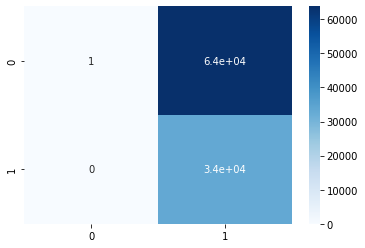

In [ ]:
model = MLP(244, 50, 1, torch.nn.ReLU())
model.load_state_dict(torch.load("gdrive/MyDrive/models_backup/model_last_optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_1_num_neuron_50_activationReLU().pt"))
loss, (all_targets, all_preds, all_preds_proba) = test(model, test_loader, 'cross_entropy')
plotLossGraph("gdrive/MyDrive/models_backup/losses__optim_adagrad_criterion_MSE_lr_0.0005_num_hidden_1_num_neuron_50_activationReLU().pt.csv")
get_metrics(all_targets, all_preds, all_preds_proba)

## sklearn MLP (good results)

Com o sklearn, perdemos algumas features que já havíamos implementado no pytorch (salvar modelo, loss customizada, gráficos de loss). Apesar disso, o skLearn nos supreendeu com uma convergência bastante mais rápida do que a que tivemos no pytorch, graças a isso foi possível executar os experimentos sem muitos reveses. Uma particularidade do sklearn é que ele não permite definir previamente qual será o conjunto de dados utilizado para validação. Com isso, foi necessário juntar as instâncias de treino e de validação em um só arquivo, e deixar o Sklearn executar seu algoritmo de k-folds.

Para todos os treinos, definimos como número máximo de iterações 10.000 épocas, com critério de paciência 30.

Iniciamos testando uma rede com 5 neurônios e taxa de aprendizado 0.0005, mas curiosamente, com o Sklearn ela não foi capaz de convergir. Também no caso (5,5) não obtivemos bons resultados (eles foram excluidos dos experimentos abaixo, para diminuir a quantidade de outputs). Optamos por, nos testes subsequentes usar somente uma camada escondida. 

Com 10 neurônios começamos a obter uma certa separação do conjunto de dados, e resolvemos aumentar nossa rede para um valor maior.

In [ ]:
from sklearn.neural_network import MLPClassifier

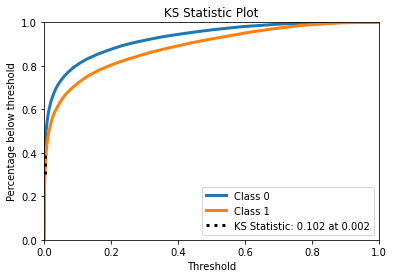

auroc   0.5208837522154316
MSE   0.34093525179856116
confusion_matrix   [[61565  2210]
 [30963  2562]]
classification_report                 precision    recall  f1-score   support

           0       0.67      0.97      0.79     63775
           1       0.54      0.08      0.13     33525

    accuracy                           0.66     97300
   macro avg       0.60      0.52      0.46     97300
weighted avg       0.62      0.66      0.56     97300



{'MSE': 0.34093525179856116,
 'auroc': 0.5208837522154316,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.67      0.97      0.79     63775\n           1       0.54      0.08      0.13     33525\n\n    accuracy                           0.66     97300\n   macro avg       0.60      0.52      0.46     97300\nweighted avg       0.62      0.66      0.56     97300\n',
 'confusion_matrix': array([[61565,  2210],
        [30963,  2562]])}

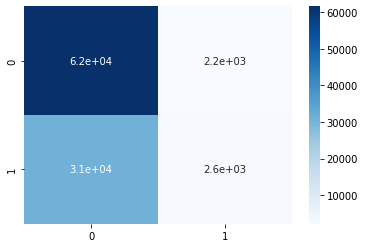

In [ ]:
mlp = MLPClassifier((10),n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.0005)
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

Na seção seguinte realizamos experimentos com 20 neurônios. Inicialmente variamos as funções de ativação para verificar qual delas trazia melhores resultados. Descobrimos que a função relu foi a que melhor performou.

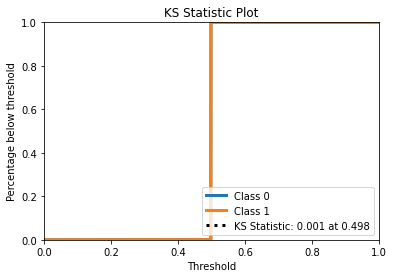

auroc   0.5001038150587084
MSE   0.34458376156217885
confusion_matrix   [[63754    21]
 [33507    18]]
classification_report                 precision    recall  f1-score   support

           0       0.66      1.00      0.79     63775
           1       0.46      0.00      0.00     33525

    accuracy                           0.66     97300
   macro avg       0.56      0.50      0.40     97300
weighted avg       0.59      0.66      0.52     97300



{'MSE': 0.34458376156217885,
 'auroc': 0.5001038150587084,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.66      1.00      0.79     63775\n           1       0.46      0.00      0.00     33525\n\n    accuracy                           0.66     97300\n   macro avg       0.56      0.50      0.40     97300\nweighted avg       0.59      0.66      0.52     97300\n',
 'confusion_matrix': array([[63754,    21],
        [33507,    18]])}

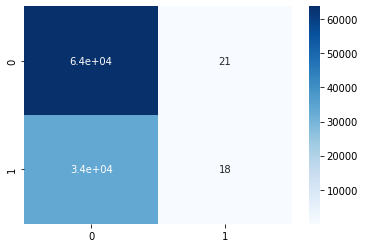

In [ ]:
mlp = MLPClassifier((20), activation = 'tanh', n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.0005, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

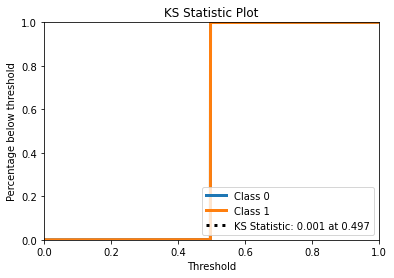

auroc   0.5000772313411915
MSE   0.344655704008222
confusion_matrix   [[63743    32]
 [33503    22]]
classification_report                 precision    recall  f1-score   support

           0       0.66      1.00      0.79     63775
           1       0.41      0.00      0.00     33525

    accuracy                           0.66     97300
   macro avg       0.53      0.50      0.40     97300
weighted avg       0.57      0.66      0.52     97300



{'MSE': 0.344655704008222,
 'auroc': 0.5000772313411915,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.66      1.00      0.79     63775\n           1       0.41      0.00      0.00     33525\n\n    accuracy                           0.66     97300\n   macro avg       0.53      0.50      0.40     97300\nweighted avg       0.57      0.66      0.52     97300\n',
 'confusion_matrix': array([[63743,    32],
        [33503,    22]])}

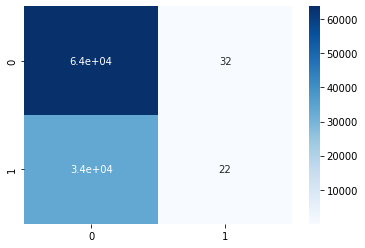

In [ ]:
mlp = MLPClassifier((20), activation = 'logistic', n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.0005, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

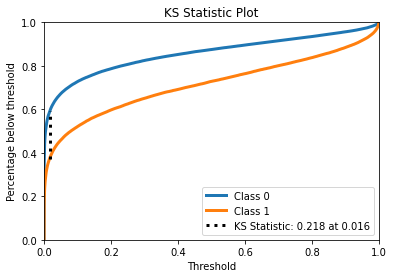

auroc   0.5732492265903825
MSE   0.33292908530318605
confusion_matrix   [[55805  7970]
 [24424  9101]]
classification_report                 precision    recall  f1-score   support

           0       0.70      0.88      0.78     63775
           1       0.53      0.27      0.36     33525

    accuracy                           0.67     97300
   macro avg       0.61      0.57      0.57     97300
weighted avg       0.64      0.67      0.63     97300



{'MSE': 0.33292908530318605,
 'auroc': 0.5732492265903825,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.70      0.88      0.78     63775\n           1       0.53      0.27      0.36     33525\n\n    accuracy                           0.67     97300\n   macro avg       0.61      0.57      0.57     97300\nweighted avg       0.64      0.67      0.63     97300\n',
 'confusion_matrix': array([[55805,  7970],
        [24424,  9101]])}

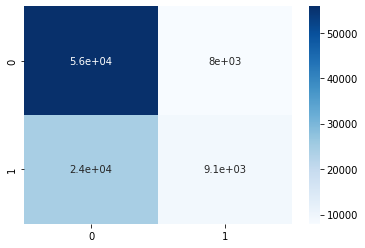

In [ ]:
mlp = MLPClassifier((20),activation = 'relu', n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.0005, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

Tendo definido a função a ser utilizada. Começamos a variar a taxa de aprendizado para verificar se era possível obter uma melhor convergência. Com um valor de 0.001 essa convergência não ocorreu.

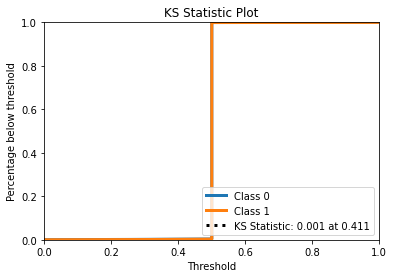

auroc   0.50034391624872
MSE   0.654059609455293
confusion_matrix   [[  236 63539]
 [  101 33424]]
classification_report                 precision    recall  f1-score   support

           0       0.70      0.00      0.01     63775
           1       0.34      1.00      0.51     33525

    accuracy                           0.35     97300
   macro avg       0.52      0.50      0.26     97300
weighted avg       0.58      0.35      0.18     97300



{'MSE': 0.654059609455293,
 'auroc': 0.50034391624872,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.70      0.00      0.01     63775\n           1       0.34      1.00      0.51     33525\n\n    accuracy                           0.35     97300\n   macro avg       0.52      0.50      0.26     97300\nweighted avg       0.58      0.35      0.18     97300\n',
 'confusion_matrix': array([[  236, 63539],
        [  101, 33424]])}

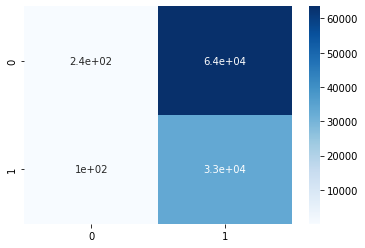

In [ ]:
mlp = MLPClassifier((20),activation = 'relu', n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.001, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

Entretanto, ao diminuirmos para 0.0007, obtivemos uma melhor convergência.

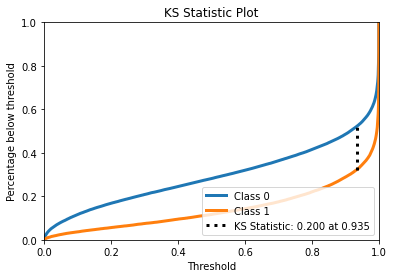

auroc   0.582582321389369
MSE   0.5109866392600205
confusion_matrix   [[17960 45815]
 [ 3904 29621]]
classification_report                 precision    recall  f1-score   support

           0       0.82      0.28      0.42     63775
           1       0.39      0.88      0.54     33525

    accuracy                           0.49     97300
   macro avg       0.61      0.58      0.48     97300
weighted avg       0.67      0.49      0.46     97300



{'MSE': 0.5109866392600205,
 'auroc': 0.582582321389369,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.82      0.28      0.42     63775\n           1       0.39      0.88      0.54     33525\n\n    accuracy                           0.49     97300\n   macro avg       0.61      0.58      0.48     97300\nweighted avg       0.67      0.49      0.46     97300\n',
 'confusion_matrix': array([[17960, 45815],
        [ 3904, 29621]])}

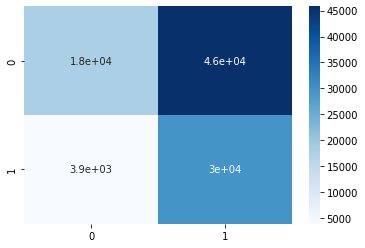

In [ ]:
mlp = MLPClassifier((20),activation = 'relu', n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.0007, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

Aqui nós fizemos experimentos com uma rede de 25 e 30 neurônios. Uma rede mais robusta geralmente requer uma taxa de aprendizado menor e um maior tempo para convergir. Baseados nesses princípios nós executamos os seguintes testes:

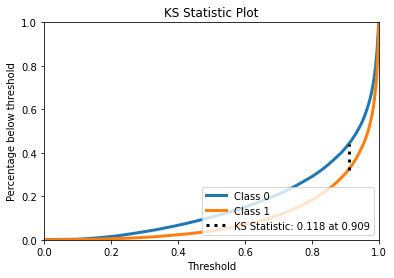

auroc   0.5316599271944064
MSE   0.60120246659815
confusion_matrix   [[ 6652 57123]
 [ 1374 32151]]
classification_report                 precision    recall  f1-score   support

           0       0.83      0.10      0.19     63775
           1       0.36      0.96      0.52     33525

    accuracy                           0.40     97300
   macro avg       0.59      0.53      0.35     97300
weighted avg       0.67      0.40      0.30     97300



{'MSE': 0.60120246659815,
 'auroc': 0.5316599271944064,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.83      0.10      0.19     63775\n           1       0.36      0.96      0.52     33525\n\n    accuracy                           0.40     97300\n   macro avg       0.59      0.53      0.35     97300\nweighted avg       0.67      0.40      0.30     97300\n',
 'confusion_matrix': array([[ 6652, 57123],
        [ 1374, 32151]])}

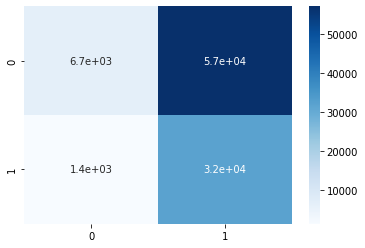

In [ ]:
mlp = MLPClassifier((25),n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.0005, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

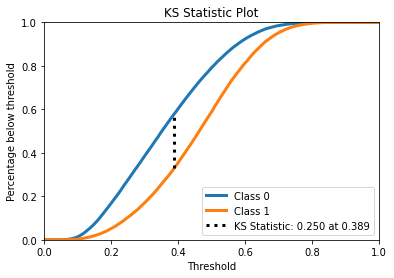

auroc   0.6016329839214403
MSE   0.33964028776978417
confusion_matrix   [[50416 13359]
 [19688 13837]]
classification_report                 precision    recall  f1-score   support

           0       0.72      0.79      0.75     63775
           1       0.51      0.41      0.46     33525

    accuracy                           0.66     97300
   macro avg       0.61      0.60      0.60     97300
weighted avg       0.65      0.66      0.65     97300



{'MSE': 0.33964028776978417,
 'auroc': 0.6016329839214403,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.72      0.79      0.75     63775\n           1       0.51      0.41      0.46     33525\n\n    accuracy                           0.66     97300\n   macro avg       0.61      0.60      0.60     97300\nweighted avg       0.65      0.66      0.65     97300\n',
 'confusion_matrix': array([[50416, 13359],
        [19688, 13837]])}

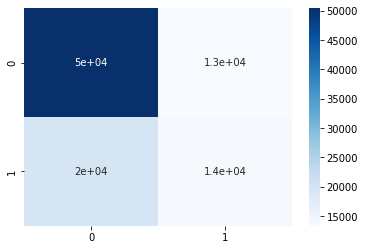

In [ ]:
mlp = MLPClassifier((30),n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.00001, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

E eis aqui a melhor rede MLP que fomos capazes de treinar, com 30 neurônios, uma hidden layer e taxa de aprendizado 0.000005: 100 vezes menor do que a utilizamos nos experimentos com 20 e 10 neurônios!

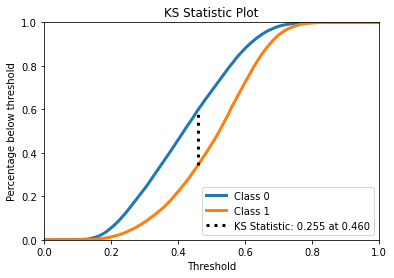

auroc   0.6223864016713774
MSE   0.35856115107913666
confusion_matrix   [[43601 20174]
 [14714 18811]]
classification_report                 precision    recall  f1-score   support

           0       0.75      0.68      0.71     63775
           1       0.48      0.56      0.52     33525

    accuracy                           0.64     97300
   macro avg       0.62      0.62      0.62     97300
weighted avg       0.66      0.64      0.65     97300



{'MSE': 0.35856115107913666,
 'auroc': 0.6223864016713774,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.75      0.68      0.71     63775\n           1       0.48      0.56      0.52     33525\n\n    accuracy                           0.64     97300\n   macro avg       0.62      0.62      0.62     97300\nweighted avg       0.66      0.64      0.65     97300\n',
 'confusion_matrix': array([[43601, 20174],
        [14714, 18811]])}

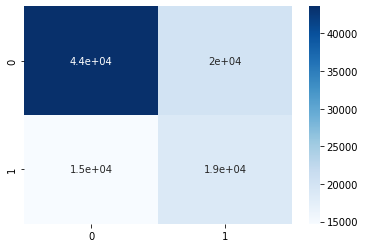

In [ ]:
mlp = MLPClassifier((30),n_iter_no_change=30, max_iter=10000, learning_rate_init = 0.000005, solver="adam")
mlp.fit(train_and_validation_x,train_and_validation_Y)
all_preds = mlp.predict(test_x)
all_preds_proba = mlp.predict_proba(test_x)
all_targets = test_Y
get_metrics(all_targets, all_preds, all_preds_proba)

## Random Forest

### First set of experiments
Here we preliminarly found min_sample_splits and max_dephts best parameters and experimented with max_samples and max_features to try improving our model.

In [ ]:
# Set of hyper-parameters for grid search

max_samples = [None, 0.75, 0.6]
# Sqrt of columns_number
max_features =  [244, 200, 150,120,90,70]
max_depths = [10]
min_samples_splits = [0.0015]
RF_test_results = []

Max_sample None Max_feature 244 Max_depht 10 Min_samples_split 0.0015


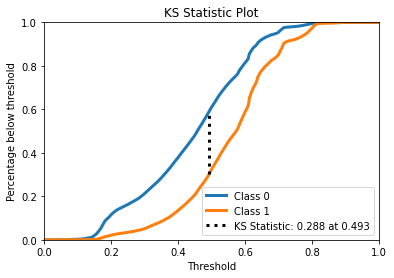

auroc   0.6431332655732089
KS   0.28626653114641776
MSE   0.3673175745118191
confusion_matrix   [[38872 24903]
 [10837 22688]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.69     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 200 Max_depht 10 Min_samples_split 0.0015


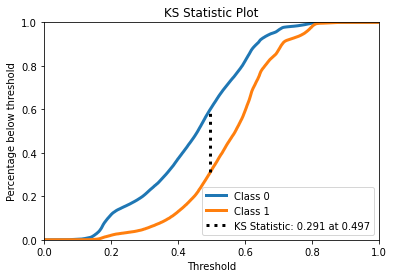

auroc   0.6448336705261875
KS   0.28966734105237496
MSE   0.36623843782117166
confusion_matrix   [[38853 24922]
 [10713 22812]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.69     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 150 Max_depht 10 Min_samples_split 0.0015


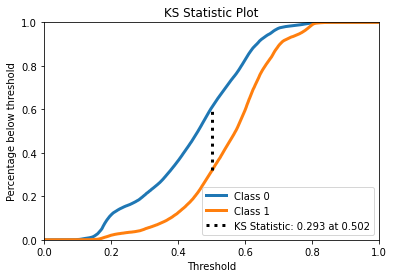

auroc   0.6460257810026686
KS   0.29205156200533716
MSE   0.3660945529290853
confusion_matrix   [[38714 25061]
 [10560 22965]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 120 Max_depht 10 Min_samples_split 0.0015


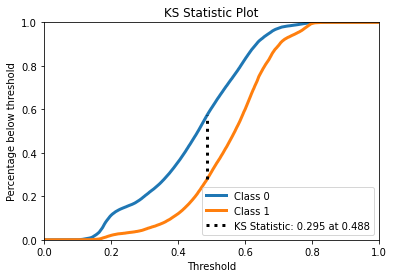

auroc   0.6467244118564432
KS   0.29344882371288644
MSE   0.36602261048304213
confusion_matrix   [[38630 25145]
 [10469 23056]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 90 Max_depht 10 Min_samples_split 0.0015


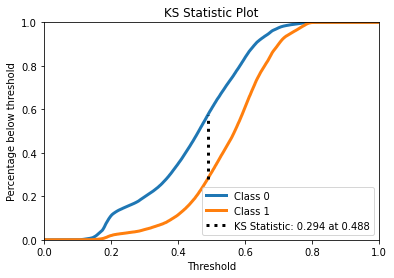

auroc   0.6465403603914887
KS   0.29308072078297726
MSE   0.3671634121274409
confusion_matrix   [[38422 25353]
 [10372 23153]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample None Max_feature 70 Max_depht 10 Min_samples_split 0.0015


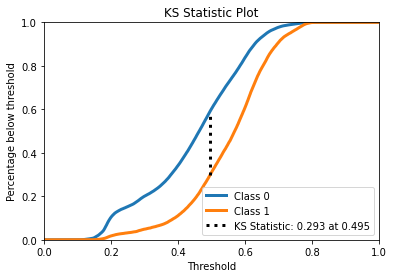

auroc   0.6462533416001854
KS   0.2925066832003709
MSE   0.36750256937307296
confusion_matrix   [[38393 25382]
 [10376 23149]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 244 Max_depht 10 Min_samples_split 0.0015


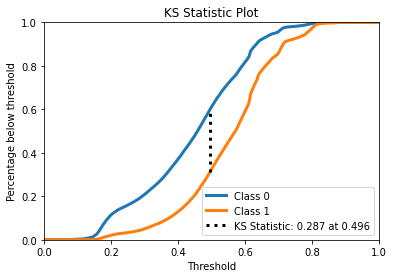

auroc   0.6430900955335905
KS   0.28618019106718107
MSE   0.3669475847893114
confusion_matrix   [[38954 24821]
 [10883 22642]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.69     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 200 Max_depht 10 Min_samples_split 0.0015


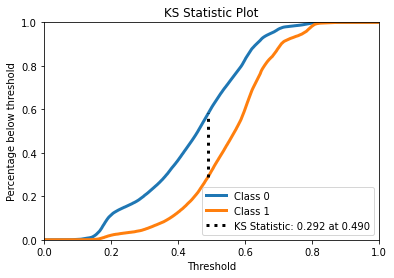

auroc   0.6453341834042652
KS   0.29066836680853037
MSE   0.3665467625899281
confusion_matrix   [[38719 25056]
 [10609 22916]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.61      0.68     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 150 Max_depht 10 Min_samples_split 0.0015


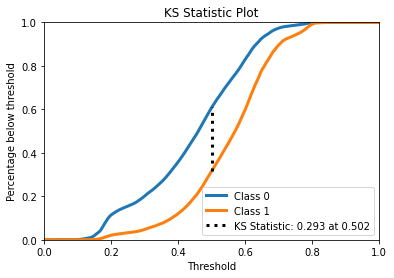

auroc   0.6462674724216586
KS   0.29253494484331716
MSE   0.3658890030832477
confusion_matrix   [[38722 25053]
 [10548 22977]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.69     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 120 Max_depht 10 Min_samples_split 0.0015


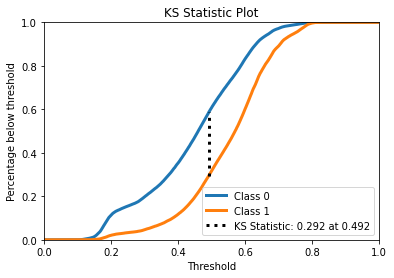

auroc   0.6454074040944303
KS   0.29081480818886074
MSE   0.36660842754367934
confusion_matrix   [[38696 25079]
 [10592 22933]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.68      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 90 Max_depht 10 Min_samples_split 0.0015


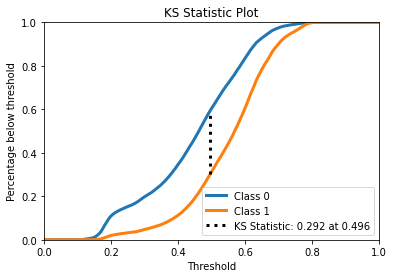

auroc   0.6459407680630573
KS   0.2918815361261145
MSE   0.36723535457348405
confusion_matrix   [[38492 25283]
 [10449 23076]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.75 Max_feature 70 Max_depht 10 Min_samples_split 0.0015


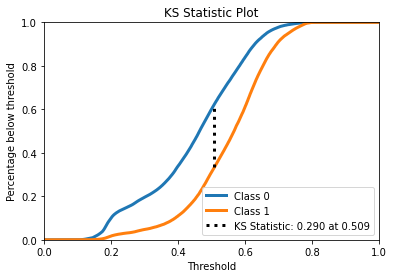

auroc   0.6448783080197528
KS   0.28975661603950553
MSE   0.36896197327852004
confusion_matrix   [[38288 25487]
 [10413 23112]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Max_sample 0.6 Max_feature 244 Max_depht 10 Min_samples_split 0.0015


KeyboardInterrupt: ignored

In [ ]:
#Experiments via grid_search
for max_sample in max_samples:
  for max_feature in max_features:
    for max_depth in max_depths:
      for min_samples_split in min_samples_splits:
        print("Max_sample " + str(max_sample) + " Max_feature " + str(max_feature) + " Max_depht " + str(max_depth) +" Min_samples_split " + str(min_samples_split))
        RF_model = RandomForestClassifier(max_depth = max_depth, max_samples = max_sample, max_features = max_feature, min_samples_split = min_samples_split)
        RF_model.fit(train_x, train_Y)
        yhat = RF_model.predict(test_x)
        y_proba = RF_model.predict_proba(test_x)
        result = get_metrics(test_Y, yhat, y_proba)
        RF_test_results.append(({"max_sample" : max_sample,"max_feature":max_feature}, result))

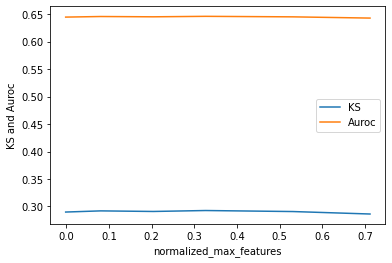

In [ ]:
results_ks = []
results_auroc = []
for dic, result in RF_test_results:
  if (dic['max_sample'] == 0.75):
    results_ks.append(result['KS'])
    results_auroc.append(result['auroc'])
  
normalized_max_features = []
for i in max_features:
  normalized_max_features.append((i-70/244-70)/244)

plt.plot(normalized_max_features, results_ks, label = "KS")
plt.plot(normalized_max_features, results_auroc, label = "Auroc")
plt.xlabel('normalized_max_features') 
plt.ylabel('KS and Auroc') 
plt.legend()
plt.show()

### Second set of experiments
After finding the best hyper_parameters on the above experiments we proceeded looking at the effect of changes on the number of estimators.

In [ ]:
# Set of hyper-parameters for grid search

n_estimators = [100, 110, 120, 130]
#Found the bellow parameters after severale experiments
max_samples = [0.75]
max_features =  [130]
max_depths = [10]
min_samples_splits = [0.0015]
RF_test_results = []

N_estimators 100 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


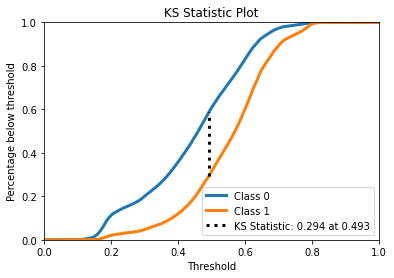

auroc   0.6462865785551192
KS   0.29257315711023824
MSE   0.36601233299075026
confusion_matrix   [[38694 25081]
 [10532 22993]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

N_estimators 110 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


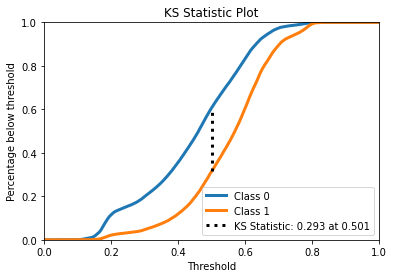

auroc   0.6461701059753147
KS   0.2923402119506292
MSE   0.3663412127440904
confusion_matrix   [[38643 25132]
 [10513 23012]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

N_estimators 120 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


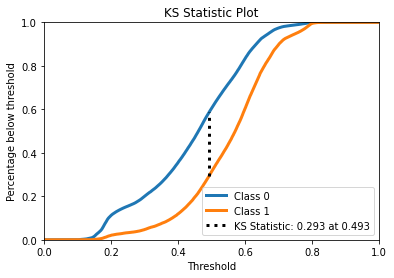

auroc   0.6458319952316516
KS   0.29166399046330327
MSE   0.36708119218910584
confusion_matrix   [[38539 25236]
 [10481 23044]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.60      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300

N_estimators 130 Max_sample 0.75 Max_feature 130 Max_depht 10 Min_samples_split 0.0015


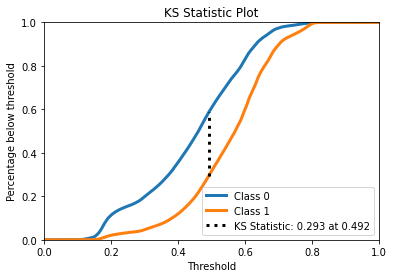

auroc   0.6456337778666436
KS   0.29126755573328705
MSE   0.36660842754367934
confusion_matrix   [[38664 25111]
 [10560 22965]]
classification_report                 precision    recall  f1-score   support

           0       0.79      0.61      0.68     63775
           1       0.48      0.69      0.56     33525

    accuracy                           0.63     97300
   macro avg       0.63      0.65      0.62     97300
weighted avg       0.68      0.63      0.64     97300



In [ ]:
#Experiments via grid_search
for n_estimator in n_estimators:
  for max_sample in max_samples:
    for max_feature in max_features:
      for max_depth in max_depths:
        for min_samples_split in min_samples_splits:
          print("N_estimators " + str(n_estimator) + " Max_sample " + str(max_sample) + " Max_feature " + str(max_feature) + " Max_depht " + str(max_depth) +" Min_samples_split " + str(min_samples_split))
          RF_model = RandomForestClassifier(max_depth = max_depth, max_samples = max_sample, max_features = max_feature, min_samples_split = min_samples_split)
          RF_model.fit(train_x, train_Y)
          yhat = RF_model.predict(test_x)
          y_proba = RF_model.predict_proba(test_x)
          result = get_metrics(test_Y, yhat, y_proba)
          RF_test_results.append((n_estimator, result))

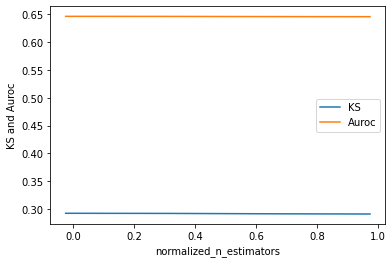

In [ ]:
results_ks = []
results_auroc = []
for _, result in RF_test_results:
  results_ks.append(result['KS'])
  results_auroc.append(result['auroc'])

normalized_n_estimators = []
for i in n_estimators:
  normalized_n_estimators.append((i-100/130-100)/30)

plt.plot(normalized_n_estimators, results_ks, label = "KS")
plt.plot(normalized_n_estimators, results_auroc, label = "Auroc")
plt.xlabel('normalized_n_estimators') 
plt.ylabel('KS and Auroc') 
plt.legend()
plt.show()


So far, RF proved to be the best model for fitting the data on our test set. 

## Ensemble MLP

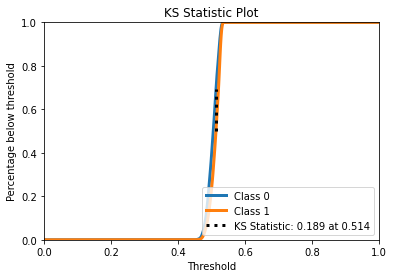

auroc   0.5750786330228003
MSE   0.4851387461459404
confusion_matrix   [[24323 39452]
 [ 7752 25773]]
classification_report                 precision    recall  f1-score   support

           0       0.76      0.38      0.51     63775
           1       0.40      0.77      0.52     33525

    accuracy                           0.51     97300
   macro avg       0.58      0.58      0.51     97300
weighted avg       0.63      0.51      0.51     97300



{'MSE': 0.4851387461459404,
 'auroc': 0.5750786330228003,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.76      0.38      0.51     63775\n           1       0.40      0.77      0.52     33525\n\n    accuracy                           0.51     97300\n   macro avg       0.58      0.58      0.51     97300\nweighted avg       0.63      0.51      0.51     97300\n',
 'confusion_matrix': array([[24323, 39452],
        [ 7752, 25773]])}

In [ ]:
model_MLP = MLPClassifier(hidden_layer_sizes=[5,5],learning_rate = 'adaptive', learning_rate_init=0.005, validation_fraction=validation_fraction, n_iter_no_change = 20, early_stopping = True, max_iter= 200)
model_bg = BaggingClassifier(base_estimator= model_MLP, n_estimators=100, bootstrap=True)

model_bg.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_bg.predict(test_x.values)
y_proba = model_bg.predict_proba(test_x.values)

get_metrics(test_Y.values, yhat, y_proba)

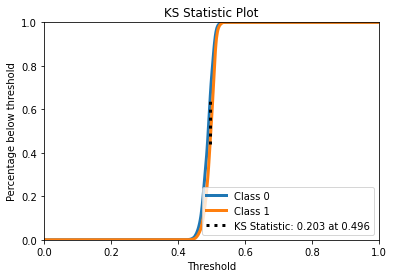

auroc   0.5966027681092441
MSE   0.35825282631038025
confusion_matrix   [[47309 16466]
 [18392 15133]]
classification_report                 precision    recall  f1-score   support

           0       0.72      0.74      0.73     63775
           1       0.48      0.45      0.46     33525

    accuracy                           0.64     97300
   macro avg       0.60      0.60      0.60     97300
weighted avg       0.64      0.64      0.64     97300



{'MSE': 0.35825282631038025,
 'auroc': 0.5966027681092441,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.72      0.74      0.73     63775\n           1       0.48      0.45      0.46     33525\n\n    accuracy                           0.64     97300\n   macro avg       0.60      0.60      0.60     97300\nweighted avg       0.64      0.64      0.64     97300\n',
 'confusion_matrix': array([[47309, 16466],
        [18392, 15133]])}

In [ ]:
model_MLP = MLPClassifier(hidden_layer_sizes=[5,5],learning_rate = 'adaptive', learning_rate_init=0.005, validation_fraction=validation_fraction, n_iter_no_change = 20, early_stopping = True, max_iter= 1000)
model_bg = BaggingClassifier(base_estimator= model_MLP, n_estimators=100, bootstrap=True)

model_bg.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_bg.predict(test_x.values)
y_proba = model_bg.predict_proba(test_x.values)

get_metrics(test_Y.values, yhat, y_proba)

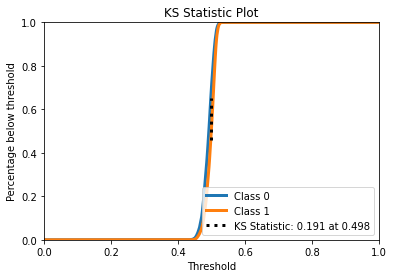

auroc   0.5943164748599122
MSE   0.37241521068859196
confusion_matrix   [[44727 19048]
 [17188 16337]]
classification_report                 precision    recall  f1-score   support

           0       0.72      0.70      0.71     63775
           1       0.46      0.49      0.47     33525

    accuracy                           0.63     97300
   macro avg       0.59      0.59      0.59     97300
weighted avg       0.63      0.63      0.63     97300



{'MSE': 0.37241521068859196,
 'auroc': 0.5943164748599122,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.72      0.70      0.71     63775\n           1       0.46      0.49      0.47     33525\n\n    accuracy                           0.63     97300\n   macro avg       0.59      0.59      0.59     97300\nweighted avg       0.63      0.63      0.63     97300\n',
 'confusion_matrix': array([[44727, 19048],
        [17188, 16337]])}

In [ ]:
model_MLP = MLPClassifier(hidden_layer_sizes=[5,5],learning_rate = 'adaptive', learning_rate_init=0.005, validation_fraction=validation_fraction, n_iter_no_change = 20, early_stopping = True, max_iter= 1000)
model_bg = BaggingClassifier(base_estimator= model_MLP, n_estimators=200, bootstrap=True)

model_bg.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_bg.predict(test_x.values)
y_proba = model_bg.predict_proba(test_x.values)

get_metrics(test_Y.values, yhat, y_proba)

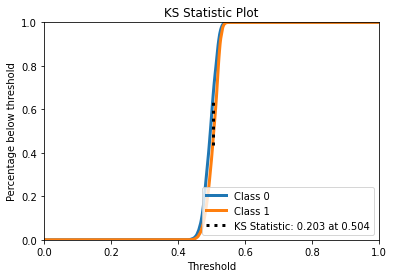

auroc   0.5986780169259998
MSE   0.4112846865364851
confusion_matrix   [[36137 27638]
 [12380 21145]]
classification_report                 precision    recall  f1-score   support

           0       0.74      0.57      0.64     63775
           1       0.43      0.63      0.51     33525

    accuracy                           0.59     97300
   macro avg       0.59      0.60      0.58     97300
weighted avg       0.64      0.59      0.60     97300



{'MSE': 0.4112846865364851,
 'auroc': 0.5986780169259998,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.74      0.57      0.64     63775\n           1       0.43      0.63      0.51     33525\n\n    accuracy                           0.59     97300\n   macro avg       0.59      0.60      0.58     97300\nweighted avg       0.64      0.59      0.60     97300\n',
 'confusion_matrix': array([[36137, 27638],
        [12380, 21145]])}

In [ ]:
model_MLP = MLPClassifier(hidden_layer_sizes=[5,5],learning_rate = 'adaptive', learning_rate_init=0.005, validation_fraction=validation_fraction, n_iter_no_change = 20, early_stopping = True, max_iter= 2000)
model_bg = BaggingClassifier(base_estimator= model_MLP, n_estimators=200, bootstrap=True)

model_bg.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_bg.predict(test_x.values)
y_proba = model_bg.predict_proba(test_x.values)

get_metrics(test_Y.values, yhat, y_proba)

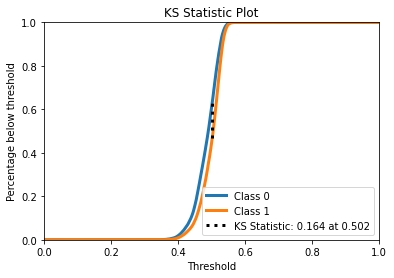

auroc   0.5806521575811682
MSE   0.41205549845837613
confusion_matrix   [[38527 25248]
 [14845 18680]]
classification_report                 precision    recall  f1-score   support

           0       0.72      0.60      0.66     63775
           1       0.43      0.56      0.48     33525

    accuracy                           0.59     97300
   macro avg       0.57      0.58      0.57     97300
weighted avg       0.62      0.59      0.60     97300



{'MSE': 0.41205549845837613,
 'auroc': 0.5806521575811682,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.72      0.60      0.66     63775\n           1       0.43      0.56      0.48     33525\n\n    accuracy                           0.59     97300\n   macro avg       0.57      0.58      0.57     97300\nweighted avg       0.62      0.59      0.60     97300\n',
 'confusion_matrix': array([[38527, 25248],
        [14845, 18680]])}

In [ ]:
model_MLP = MLPClassifier(hidden_layer_sizes=[30,30],learning_rate = 'adaptive', learning_rate_init=0.005, validation_fraction=validation_fraction, n_iter_no_change = 20, early_stopping = True, max_iter= 2000)
model_bg = BaggingClassifier(base_estimator= model_MLP, n_estimators=100, bootstrap=True, oob_score= True)

model_bg.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_bg.predict(test_x.values)
y_proba = model_bg.predict_proba(test_x.values)

get_metrics(test_Y.values, yhat, y_proba)

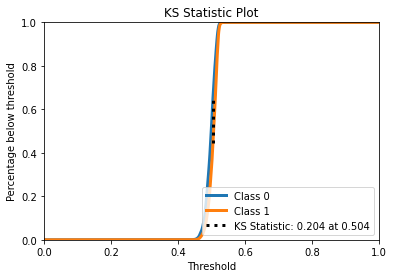

auroc   0.5961922317899051
MSE   0.42793422404933196
confusion_matrix   [[33073 30702]
 [10936 22589]]
classification_report                 precision    recall  f1-score   support

           0       0.75      0.52      0.61     63775
           1       0.42      0.67      0.52     33525

    accuracy                           0.57     97300
   macro avg       0.59      0.60      0.57     97300
weighted avg       0.64      0.57      0.58     97300



{'MSE': 0.42793422404933196,
 'auroc': 0.5961922317899051,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.75      0.52      0.61     63775\n           1       0.42      0.67      0.52     33525\n\n    accuracy                           0.57     97300\n   macro avg       0.59      0.60      0.57     97300\nweighted avg       0.64      0.57      0.58     97300\n',
 'confusion_matrix': array([[33073, 30702],
        [10936, 22589]])}

In [ ]:
model_MLP = MLPClassifier(hidden_layer_sizes=[5,5],learning_rate = 'adaptive', learning_rate_init=0.005, validation_fraction=validation_fraction, n_iter_no_change = 20, early_stopping = True, max_iter= 2000)
model_bg = BaggingClassifier(base_estimator= model_MLP, n_estimators=100, bootstrap=True, oob_score= True)

model_bg.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_bg.predict(test_x.values)
y_proba = model_bg.predict_proba(test_x.values)

get_metrics(test_Y.values, yhat, y_proba)

## Gradient Boosting

Initializing training with low learning rate and few estimators

      Iter       Train Loss   Remaining Time 
         1           1.3863           40.23m
         2           1.3863           36.20m
         3           1.3863           33.26m
         4           1.3863           31.76m
         5           1.3862           30.58m
         6           1.3862           29.77m
         7           1.3862           29.16m
         8           1.3862           28.67m
         9           1.3862           28.31m
        10           1.3862           27.97m
        20           1.3861           26.03m
        30           1.3860           25.10m
        40           1.3859           23.73m
        50           1.3858           22.48m
        60           1.3857           21.28m
        70           1.3855           20.71m
        80           1.3854           19.48m
        90           1.3853           18.29m
       100           1.3852           17.13m
       200           1.3842            5.66m


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


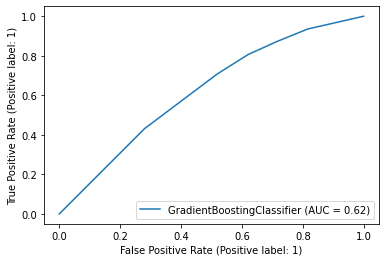

In [ ]:
model_GB = GradientBoostingClassifier(learning_rate = 0.0001, criterion = 'squared_error', n_estimators=250, min_samples_leaf = 0.08, validation_fraction= validation_fraction , n_iter_no_change=30,verbose=1)
model_GB.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_GB.predict(test_x.values)
y_proba = model_GB.predict_proba(test_x.values)

metrics.plot_roc_curve(model_GB, test_x.values, test_Y.values) 



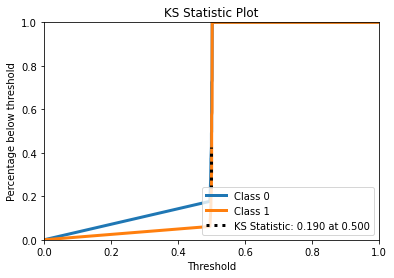

auroc   0.5943523836333868
MSE   0.43847893114080166
confusion_matrix   [[31170 32605]
 [10059 23466]]
classification_report                 precision    recall  f1-score   support

           0       0.76      0.49      0.59     63775
           1       0.42      0.70      0.52     33525

    accuracy                           0.56     97300
   macro avg       0.59      0.59      0.56     97300
weighted avg       0.64      0.56      0.57     97300



{'MSE': 0.43847893114080166,
 'auroc': 0.5943523836333868,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.76      0.49      0.59     63775\n           1       0.42      0.70      0.52     33525\n\n    accuracy                           0.56     97300\n   macro avg       0.59      0.59      0.56     97300\nweighted avg       0.64      0.56      0.57     97300\n',
 'confusion_matrix': array([[31170, 32605],
        [10059, 23466]])}

In [ ]:

get_metrics(test_Y.values, yhat, y_proba)

increasing learning rate in 5x and doubling estimators

      Iter       Train Loss   Remaining Time 
         1           1.3862           75.91m
         2           1.3862           76.08m
         3           1.3861           77.30m
         4           1.3861           76.46m
         5           1.3860           76.08m
         6           1.3860           75.74m
         7           1.3859           75.37m
         8           1.3859           74.98m
         9           1.3858           74.69m
        10           1.3858           76.76m
        20           1.3852           73.88m
        30           1.3847           72.28m
        40           1.3842           70.34m
        50           1.3837           68.42m
        60           1.3832           66.69m
        70           1.3827           65.11m
        80           1.3822           63.55m
        90           1.3817           62.10m
       100           1.3813           60.55m
       200           1.3767           45.06m
       300           1.3725           29.80m
       40

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


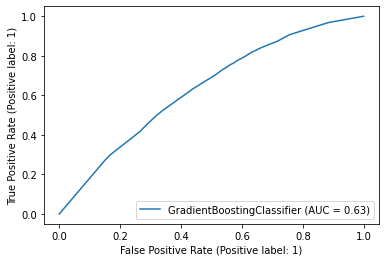

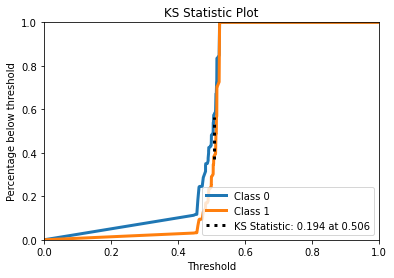

auroc   0.5955705107236682
MSE   0.43997944501541625
confusion_matrix   [[30690 33085]
 [ 9725 23800]]
classification_report                 precision    recall  f1-score   support

           0       0.76      0.48      0.59     63775
           1       0.42      0.71      0.53     33525

    accuracy                           0.56     97300
   macro avg       0.59      0.60      0.56     97300
weighted avg       0.64      0.56      0.57     97300



{'MSE': 0.43997944501541625,
 'auroc': 0.5955705107236682,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.76      0.48      0.59     63775\n           1       0.42      0.71      0.53     33525\n\n    accuracy                           0.56     97300\n   macro avg       0.59      0.60      0.56     97300\nweighted avg       0.64      0.56      0.57     97300\n',
 'confusion_matrix': array([[30690, 33085],
        [ 9725, 23800]])}

In [ ]:
model_GB = GradientBoostingClassifier(learning_rate = 0.0005, criterion = 'friedman_mse', n_estimators=500, min_samples_leaf = 0.08, validation_fraction= validation_fraction , n_iter_no_change=30,warm_start = True, verbose=1)
model_GB.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_GB.predict(test_x.values)
y_proba = model_GB.predict_proba(test_x.values)

metrics.plot_roc_curve(model_GB, test_x.values, test_Y.values) 
get_metrics(test_Y.values, yhat, y_proba)

increasing 300 estimators and reducing min samples in leaf

      Iter       Train Loss   Remaining Time 
         1           1.3862          120.27m
         2           1.3862          120.76m
         3           1.3861          120.68m
         4           1.3860          120.41m
         5           1.3860          120.13m
         6           1.3859          119.92m
         7           1.3859          119.66m
         8           1.3858          119.43m
         9           1.3857          119.32m
        10           1.3857          120.06m
        20           1.3851          119.22m
        30           1.3845          117.73m
        40           1.3839          116.20m
        50           1.3833          114.54m
        60           1.3827          112.89m
        70           1.3821          111.28m
        80           1.3815          109.66m
        90           1.3809          108.04m
       100           1.3804          106.47m
       200           1.3750           91.53m
       300           1.3701           76.36m
       40

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


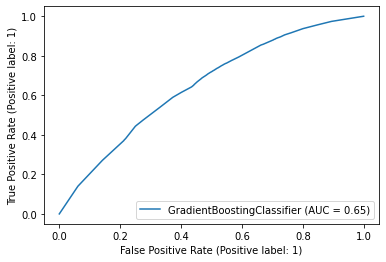

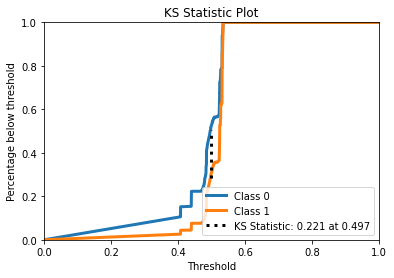

auroc   0.6095830296843717
MSE   0.4159815005138746
confusion_matrix   [[33632 30143]
 [10332 23193]]
classification_report                 precision    recall  f1-score   support

           0       0.76      0.53      0.62     63775
           1       0.43      0.69      0.53     33525

    accuracy                           0.58     97300
   macro avg       0.60      0.61      0.58     97300
weighted avg       0.65      0.58      0.59     97300



{'MSE': 0.4159815005138746,
 'auroc': 0.6095830296843717,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.76      0.53      0.62     63775\n           1       0.43      0.69      0.53     33525\n\n    accuracy                           0.58     97300\n   macro avg       0.60      0.61      0.58     97300\nweighted avg       0.65      0.58      0.59     97300\n',
 'confusion_matrix': array([[33632, 30143],
        [10332, 23193]])}

In [ ]:
model_GB = GradientBoostingClassifier(learning_rate = 0.0005, criterion = 'friedman_mse', n_estimators=800, min_samples_leaf = 0.05, validation_fraction= validation_fraction , n_iter_no_change=30,warm_start = True, verbose=1)
model_GB.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_GB.predict(test_x.values)
y_proba = model_GB.predict_proba(test_x.values)

metrics.plot_roc_curve(model_GB, test_x.values, test_Y.values) 
get_metrics(test_Y.values, yhat, y_proba)

increasing learning rate in 10x, add 200 estimators and modify depth for 10

      Iter       Train Loss   Remaining Time 
         1           1.3856          457.74m
         2           1.3849          352.75m
         3           1.3842          313.65m
         4           1.3835          296.69m
         5           1.3828          283.84m
         6           1.3821          278.52m
         7           1.3814          272.67m
         8           1.3808          269.31m
         9           1.3801          267.50m
        10           1.3794          263.71m
        20           1.3731          253.30m
        30           1.3671          250.14m
        40           1.3616          248.06m
        50           1.3565          246.84m
        60           1.3517          246.66m
        70           1.3474          245.72m
        80           1.3433          243.92m
        90           1.3397          240.88m
       100           1.3363          237.08m
       200           1.3077          211.37m
       300           1.2915          184.81m
       40

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


NameError: ignored

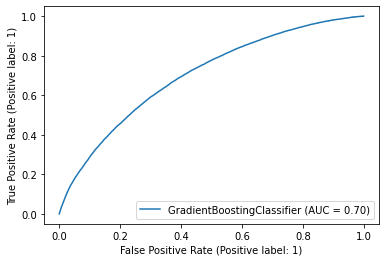

In [ ]:
model_GB = GradientBoostingClassifier(learning_rate = 0.005, criterion = 'friedman_mse', n_estimators=1000, max_depth= 10, min_samples_leaf = 0.05, validation_fraction= validation_fraction , n_iter_no_change=30,warm_start = True, verbose=1)
model_GB.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_GB.predict(test_x.values)
y_proba = model_GB.predict_proba(test_x.values)

metrics.plot_roc_curve(model_GB, test_x.values, test_Y.values) 
get_metrics(test_Y.values, yhat, y_proba)

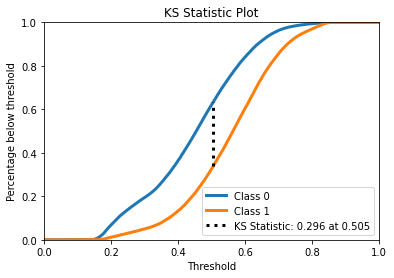

auroc   0.6473138138572669
MSE   0.36115107913669064
confusion_matrix   [[39546 24229]
 [10911 22614]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.62      0.69     63775
           1       0.48      0.67      0.56     33525

    accuracy                           0.64     97300
   macro avg       0.63      0.65      0.63     97300
weighted avg       0.68      0.64      0.65     97300



{'MSE': 0.36115107913669064,
 'auroc': 0.6473138138572669,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.78      0.62      0.69     63775\n           1       0.48      0.67      0.56     33525\n\n    accuracy                           0.64     97300\n   macro avg       0.63      0.65      0.63     97300\nweighted avg       0.68      0.64      0.65     97300\n',
 'confusion_matrix': array([[39546, 24229],
        [10911, 22614]])}

In [ ]:
get_metrics(test_Y.values, yhat, y_proba)

increasing learning rate in 20x and add 200 estimators

      Iter       Train Loss   Remaining Time 
         1           1.3848          508.01m
         2           1.3834          413.23m
         3           1.3820          382.78m
         4           1.3806          373.51m
         5           1.3793          359.01m
         6           1.3779          363.28m
         7           1.3766          355.28m
         8           1.3754          348.54m
         9           1.3742          345.30m
        10           1.3730          341.03m
        20           1.3620          326.04m
        30           1.3525          319.61m
        40           1.3444          316.09m
        50           1.3375          312.36m
        60           1.3312          309.63m
        70           1.3240          306.02m
        80           1.3179          302.79m
        90           1.3133          296.74m
       100           1.3089          292.25m
       200           1.2827          259.31m
       300           1.2686          240.17m
       40

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


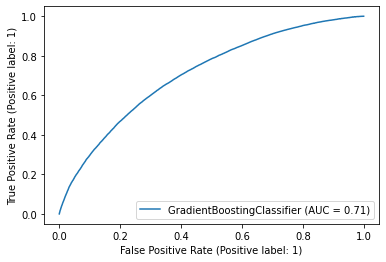

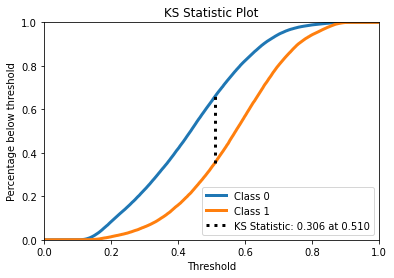

auroc   0.6519211339969616
MSE   0.35295991778006164
confusion_matrix   [[40575 23200]
 [11143 22382]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.64      0.70     63775
           1       0.49      0.67      0.57     33525

    accuracy                           0.65     97300
   macro avg       0.64      0.65      0.63     97300
weighted avg       0.68      0.65      0.66     97300



{'MSE': 0.35295991778006164,
 'auroc': 0.6519211339969616,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.78      0.64      0.70     63775\n           1       0.49      0.67      0.57     33525\n\n    accuracy                           0.65     97300\n   macro avg       0.64      0.65      0.63     97300\nweighted avg       0.68      0.65      0.66     97300\n',
 'confusion_matrix': array([[40575, 23200],
        [11143, 22382]])}

In [ ]:
model_GB = GradientBoostingClassifier(learning_rate = 0.01, criterion = 'friedman_mse', n_estimators=1200, max_depth= 10, min_samples_leaf = 0.05, validation_fraction= validation_fraction , n_iter_no_change=30,warm_start = True, verbose=1)
model_GB.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_GB.predict(test_x.values)
y_proba = model_GB.predict_proba(test_x.values)

metrics.plot_roc_curve(model_GB, test_x.values, test_Y.values) 
get_metrics(test_Y.values, yhat, y_proba)

increasing learning rate in 4x and add 300 estimators

      Iter       Train Loss   Remaining Time 
         1           1.3803          497.44m
         2           1.3749          458.89m
         3           1.3698          445.71m
         4           1.3652          439.68m
         5           1.3609          438.16m
         6           1.3569          433.06m
         7           1.3531          428.71m
         8           1.3493          433.23m
         9           1.3461          428.89m
        10           1.3430          429.47m
        20           1.3171          421.67m
        30           1.3000          407.93m
        40           1.2890          399.00m
        50           1.2814          397.15m
        60           1.2746          396.56m
        70           1.2690          400.70m
        80           1.2651          401.30m
        90           1.2618          402.09m
       100           1.2592          402.35m
       200           1.2435          384.04m
       300           1.2358          361.31m
       40

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


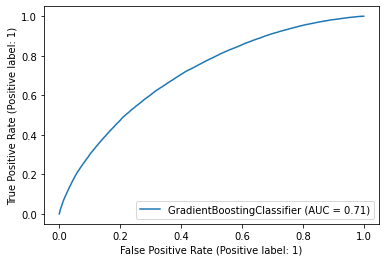

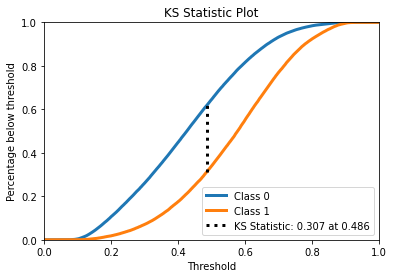

auroc   0.6527975314033682
MSE   0.349743062692703
confusion_matrix   [[41111 22664]
 [11366 22159]]
classification_report                 precision    recall  f1-score   support

           0       0.78      0.64      0.71     63775
           1       0.49      0.66      0.57     33525

    accuracy                           0.65     97300
   macro avg       0.64      0.65      0.64     97300
weighted avg       0.68      0.65      0.66     97300



{'MSE': 0.349743062692703,
 'auroc': 0.6527975314033682,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.78      0.64      0.71     63775\n           1       0.49      0.66      0.57     33525\n\n    accuracy                           0.65     97300\n   macro avg       0.64      0.65      0.64     97300\nweighted avg       0.68      0.65      0.66     97300\n',
 'confusion_matrix': array([[41111, 22664],
        [11366, 22159]])}

In [ ]:
model_GB = GradientBoostingClassifier(learning_rate = 0.04, criterion = 'friedman_mse', n_estimators=1500, max_depth=8, min_samples_leaf = 0.05, validation_fraction= validation_fraction , n_iter_no_change=30,warm_start = True, verbose=1)
model_GB.fit(train_and_validation_x.values, train_and_validation_Y.values)

yhat = model_GB.predict(test_x.values)
y_proba = model_GB.predict_proba(test_x.values)

metrics.plot_roc_curve(model_GB, test_x.values, test_Y.values) 
get_metrics(test_Y.values, yhat, y_proba)

##SVM

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error

class SVM:
  def __init__(self, learning_rate= 1e-3, lambda_param= 1e-2, epochs=100):
    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.epochs = epochs
    self.w = None
    self.b = None
    self.kernel = rbf_kernel()

  def _init_weights_bias(self, X):
    n_features = X.shape[1]
    self.w = np.zeros(n_features)
    self.b = 0
  
  def get_map_y(self, y):
    return np.where(y<=0,-1,1)

  def satisfyConstraint(self, x, idx):
    linear_model = np.dot(x, self.w) + self.b
    return self.map_y[idx]*linear_model >= 1

  def get_gradients(self, constrain, x, idx):
    if constrain:
      dw = self.lambda_param * self.w
      db = 0
      return dw, db

    dw = self.lambda_param * self.w - np.dot(self.map_y[idx], x)
    db = - self.map_y[idx]
    return dw, db

  def update_weights_bias(self, dw, db):
      self.w -= self.lr * dw 
      self.b -= self.lr * db
      #incluir save

  def fit(self, X, y):
    pacience = 20
    counter = 0
    current_loss = 0
    last_loss = 0

    self._init_weights_bias(X)
    self.map_y = self.get_map_y(y) 

    #--
    for i in range(self.epochs):
      print('epoch:'+str(i))
      for idx, x in enumerate(X):
        constrain = self.satisfyConstraint(x,idx)
        dw, db = self.get_gradients(constrain,x,idx)
        self.update_weights_bias(dw,db)

      yhat = self.predict(validation_x)
      current_loss = mean_squared_error(validation_Y, yhat)
      print('loss: '+ str(current_loss))
      if(current_loss >= last_loss):
        counter = counter +1

      if (counter == pacience):
        break
      else:
       counter = 0
      
      last_loss = current_loss 
  
  def predict(self, X):
    estimate = np.dot(X, self.w) + self.b
    prediction = np.sign(estimate)
    pred = np.where(prediction == -1,0,1)
    return pred

In [ ]:
SVM_model = SVM(learning_rate=0.0001, epochs=10000)
SVM_model.fit(train_data.data_features, train_data.data_labels)
pred=SVM_model.predict(validation_data.data_features)

A saída de streaming foi truncada nas últimas 5000 linhas.
loss: 0.4999921598143444
epoch:1246
loss: 0.4999921598143444
epoch:1247
loss: 0.4999921598143444
epoch:1248
loss: 0.4999921598143444
epoch:1249
loss: 0.4999764794430332
epoch:1250
loss: 0.4999921598143444
epoch:1251
loss: 0.4999921598143444
epoch:1252
loss: 0.4999921598143444
epoch:1253
loss: 0.4999921598143444
epoch:1254
loss: 0.4999921598143444
epoch:1255
loss: 0.4999921598143444
epoch:1256
loss: 0.4999921598143444
epoch:1257
loss: 0.4999764794430332
epoch:1258
loss: 0.4999921598143444
epoch:1259
loss: 0.4999921598143444
epoch:1260
loss: 0.4999921598143444
epoch:1261
loss: 0.4999921598143444
epoch:1262
loss: 0.4999921598143444
epoch:1263
loss: 0.4999921598143444
epoch:1264
loss: 0.4999921598143444
epoch:1265
loss: 0.4999764794430332
epoch:1266
loss: 0.4999921598143444
epoch:1267
loss: 0.4999921598143444
epoch:1268
loss: 0.4999921598143444
epoch:1269
loss: 0.4999921598143444
epoch:1270
loss: 0.4999921598143444
epoch:1271
loss:

In [ ]:
accuracy_score(validation_data.data_labels, pred)

0.5